In [1]:
import re
import json

In [3]:
with open('Top10_Communities.json', encoding='utf-8-sig') as f:
    data = json.load(f)
    
with open('Conference_Id_name.json',encoding='utf-8-sig') as f:
    conference_data = json.load(f)

In [4]:
conference_data_dict = dict()
for conf_data in conference_data:
    conference_data_dict[conf_data['Id_Venue']] = conf_data['conference name']

conference_data_dict

{30: 'international conference of the ieee engineering in medicine and biology society',
 65: 'robot and human interactive communication',
 104: 'symposium on principles of database systems',
 122: 'acm sigplan symposium on principles and practice of parallel programming',
 208: 'mobile adhoc and sensor systems',
 235: 'international conference on computational linguistics',
 256: 'international conference on learning representations',
 293: 'passive and active network measurement',
 339: 'computer and communications security',
 343: 'hot topics in networks',
 344: 'conference of the european chapter of the association for computational linguistics',
 369: 'vehicular technology conference',
 374: 'european symposium on research in computer security',
 390: 'international symposium on biomedical imaging',
 422: 'knowledge discovery and data mining',
 507: 'international conference on management of data',
 517: 'international conference on software testing verification and validation',
 

In [5]:
import re
import random
import numpy as np
import pandas as pd 
from pprint import pprint
from collections import Counter, OrderedDict

import gensim
import gensim.corpora as corpora
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import pyLDAvis
from pyLDAvis import gensim_models

from wordcloud import WordCloud

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import plotly.express as px


%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)  

stop_words = set(stopwords.words('english'))
latex_regex = r"(\$+)(?:(?!\1)[\s\S])*\1"
lmtzr = WordNetLemmatizer()

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/pylab/backend_inline.py:164: DeprecationWarning: `configure_inline_support` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.configure_inline_support()`
  configure_inline_support(ip, backend)


In [6]:
def color_func(**kwargs):
    return "hsl(0, {}%, 50%)".format(random.randint(0, 50))

In [7]:
papers = pd.DataFrame(data)
papers.dropna(inplace=True)
papers.head()

ID_Article  communityId  ID_RelatedVenue  \
0     2897211        21220               30   
1     2950694        21235               30   
2     2922123        21235               30   
3     2921960        21235               30   
4     2981319        21246               30   

                                               title  year  \
0  A wide range and high sensitivity four-channel...  2016   
1  Recent machine learning advancements in sensor...  2016   
2  Automatic grasp selection using a camera in a ...  2016   
3  Automatic tissue characterization of air trapp...  2016   
4  Unified phase variables of relative degree two...  2016   

                                            abstract  
0  We present a four-channel, high-sensitivity an...  
1  The development of wearable sensors has opened...  
2  In this paper, we demonstrate how automatic gr...  
3  Significant progress has been made in recent y...  
4  A starting point to achieve stable locomotion ...

In [8]:
papers['communityId'].value_counts()

21220    13607
21349    13468
21239    12344
22736    11616
21246    10947
21212    10306
20178    10049
21235     8606
22457     7875
21258     3506
Name: communityId, dtype: int64

In [9]:
# Input Community to perform analysis on
community_id_to_use = 22457

In [10]:
df = papers[papers['communityId'] == community_id_to_use]
df.head()

ID_Article  communityId  ID_RelatedVenue  \
78       2467519        22457               65   
1277     2653647        22457              369   
3849     2096298        22457              369   
3926     2110864        22457              369   
5182     1920673        22457              369   

                                                  title  year  \
78             Recognizing situations that demand trust  2011   
1277  Towards Mobility-as-a-Service to Promote Smart...  2015   
3849  QoS-Aware Load Balancing Algorithm for Joint G...  2012   
3926  Performance Improvements with a P-Persistent E...  2006   
5182  A Combined Design to Provide QoS for Mobile Ad...  2007   

                                               abstract  
78    This article presents an investigation into th...  
1277  In this paper, we present a mobility cloud pla...  
3849  In heterogeneous network, it is likely that ma...  
3926  This paper focuses on the design and performan...  
5182  To transmit real-time traffic in mobile ad hoc...

We will first take a look at the papers in the community disributed by the year they were published in and see if we can find any patterns in it. 

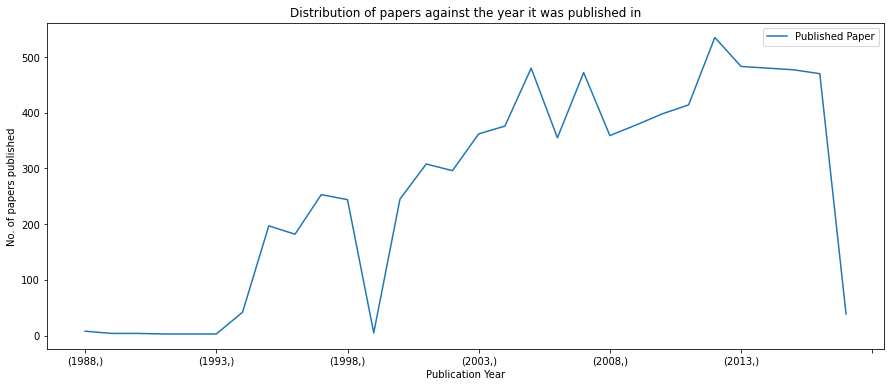

In [11]:
ax = df[['year']].sort_values(by='year').value_counts(sort=False).plot( 
                                                                       figsize=(15,6), 
                                                                       title='Distribution of papers against the year it was published in')
ax.set_xlabel('Publication Year')
ax.set_ylabel('No. of papers published')
plt.legend(["Published Paper"])

We see that most of the papers in the community were published in the years after 2001 with year 2009 accounting for the highest number of papers with 368 papers

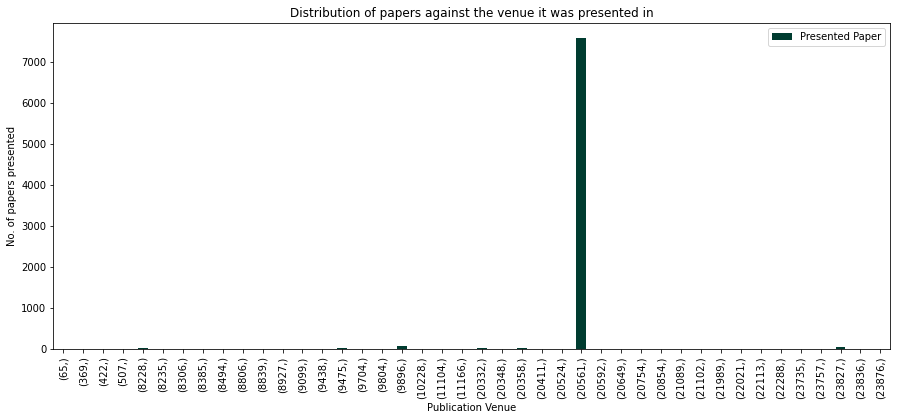

In [12]:
ax = df[['ID_RelatedVenue']].value_counts(sort=False).plot(kind='bar',colormap = 'BrBG_r',
                                                                       figsize=(15,6), 
                                                                       title='Distribution of papers against the venue it was presented in')
ax.set_xlabel('Publication Venue')
ax.set_ylabel('No. of papers presented')
plt.legend(["Presented Paper"])

In [42]:
print(conference_data_dict[20561])

hawaii international conference on system sciences


One interesting thing we can note here is that most papers of the community were presented at the same venue. The venue_id where majority of the papers were presented is 20561 which corresponds to the **Hawaii International Conference on System Sciences**, Hence most of the papers in the community are from that conference. 

In [14]:
plot_df = pd.DataFrame()

## Analyzing the title of the papers

We will initially plot a wordcloud of the 1000 most used terms in the titles of the papers of the community and see which are the most commonly used words in the titles of the papers

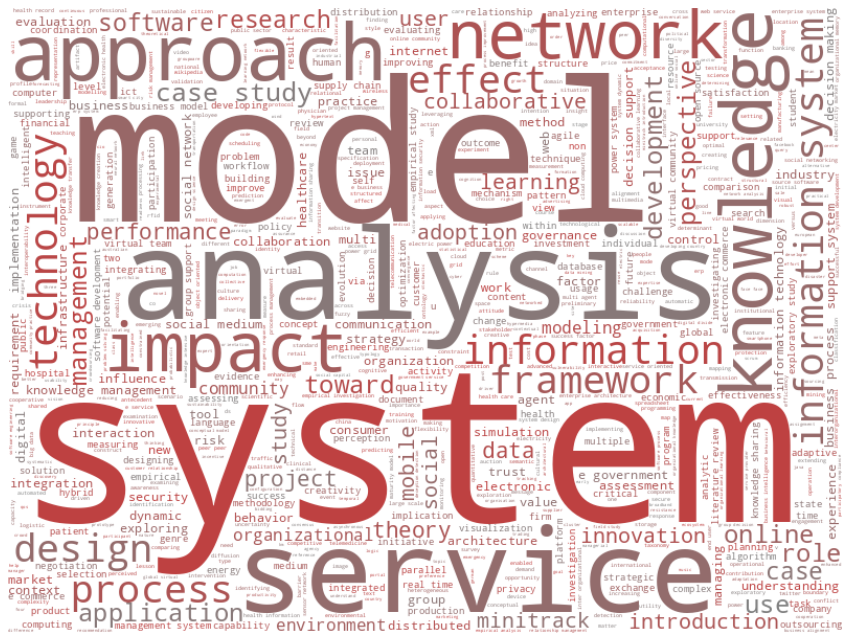

In [15]:
stop_words.update(['based', 'using', 'A', 'The'])

plot_df['tokenized_col'] = df.apply(lambda row: (re.sub("[^A-Za-z0-9' ]+", ' ', row['title'])),axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: row['tokenized_col'].lower(), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: (word_tokenize(row['tokenized_col'])), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([w for w in row['tokenized_col'] if w not in stop_words]), axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([lmtzr.lemmatize(w) for w in row['tokenized_col']]), axis=1)
plot_df['col'] = plot_df.apply(lambda row: ' '.join(row['tokenized_col']), axis=1)
all_titles = ' '.join(plot_df['col'].str.lower())

wordcloud = WordCloud(stopwords=stop_words, background_color="white", 
                      max_words=1000, width=800, height=600).generate(all_titles)
default_colors = wordcloud.to_array() #convert to array for recoloring

rcParams['figure.figsize'] = 15, 25
plt.imshow(wordcloud.recolor(color_func=color_func), #apply recoloring using color function
           interpolation="bilinear")
plt.axis("off")
plt.show()

Looking at the wordcloud, the most common terms we seem to get are model, analysis, system, etc. 

Next we take a look at top 30 words and the number of times they have been used in the paper titles.

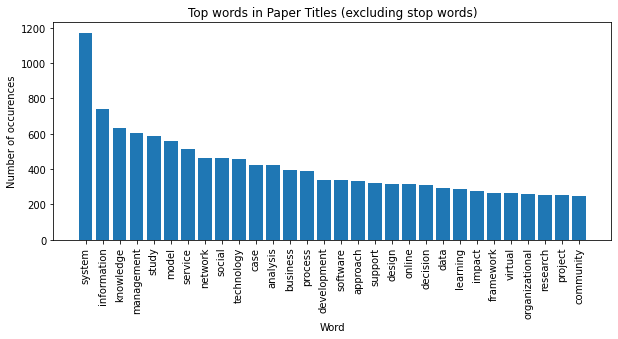

In [16]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])


count_vectorizer = CountVectorizer(stop_words=stop_words)
words, word_values = get_top_n_words(n_top_words=30,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=plot_df['col'])

fig, ax = plt.subplots(figsize=(10,4))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in Paper Titles (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

system, information, knowledegs, management are the terms that seem to make up most of the used words in the paper titles

We apply Latent Discriminant Analysis (LDA) for topic modelling using only the titles of the papers

In [17]:
dictionary = corpora.Dictionary(plot_df['tokenized_col'])
texts = plot_df['tokenized_col']
corpus = [dictionary.doc2bow(text) for text in plot_df['tokenized_col']]

In [18]:
tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [19]:
total_topics = 10

lda = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tf

In [20]:
lda.show_topics(total_topics,6)

[(0,
  '0.018*"technology" + 0.016*"network" + 0.014*"information" + 0.012*"learning" + 0.011*"collaborative" + 0.009*"communication"'),
 (1,
  '0.045*"system" + 0.023*"online" + 0.020*"information" + 0.020*"support" + 0.020*"community" + 0.018*"decision"'),
 (2,
  '0.030*"minitrack" + 0.029*"introduction" + 0.021*"development" + 0.021*"software" + 0.016*"study" + 0.014*"process"'),
 (3,
  '0.018*"system" + 0.015*"market" + 0.014*"knowledge" + 0.011*"power" + 0.011*"analysis" + 0.010*"technology"'),
 (4,
  '0.051*"social" + 0.020*"medium" + 0.019*"network" + 0.015*"study" + 0.012*"perspective" + 0.012*"knowledge"'),
 (5,
  '0.020*"system" + 0.017*"agent" + 0.015*"service" + 0.012*"simulation" + 0.012*"approach" + 0.010*"model"'),
 (6,
  '0.024*"data" + 0.019*"model" + 0.017*"analysis" + 0.017*"service" + 0.015*"towards" + 0.014*"business"'),
 (7,
  '0.028*"e" + 0.023*"web" + 0.019*"service" + 0.018*"security" + 0.016*"system" + 0.015*"study"'),
 (8,
  '0.028*"system" + 0.010*"supply" +

The above list of tuples show which terms are most important to which topic. The numbers attached to each term represents the weightages given to that term for the corresponding topic.

In [21]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
df_lda

technology   network  information  learning  collaborative  communication  \
0    0.018430  0.016185     0.013949  0.012057       0.011134       0.008846   
1    0.000000  0.000000     0.020018  0.000000       0.000000       0.000000   
2    0.008072  0.000000     0.006880  0.000000       0.007115       0.000000   
3    0.010209  0.008791     0.007314  0.000000       0.000000       0.000000   
4    0.006749  0.018958     0.008711  0.000000       0.000000       0.000000   
5    0.000000  0.007054     0.007918  0.000000       0.007826       0.000000   
6    0.000000  0.000000     0.000000  0.000000       0.000000       0.000000   
7    0.000000  0.000000     0.013523  0.010932       0.000000       0.000000   
8    0.006013  0.007396     0.007894  0.000000       0.000000       0.000000   
9    0.011752  0.000000     0.025800  0.000000       0.000000       0.000000   

     impact  behavior    health  platform  ...      real  electric  resource  \
0  0.008516  0.008308  0.007238  0.006903  ...  0.000000  0.000000  0.000000   
1  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
2  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
3  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
4  0.006487  0.000000  0.008421  0.000000  ...  0.000000  0.000000  0.000000   
5  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
6  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
7  0.000000  0.000000  0.005975  0.000000  ...  0.000000  0.000000  0.000000   
8  0.000000  0.006265  0.000000  0.000000  ...  0.006251  0.006002  0.005915   
9  0.009919  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   

   organizational  innovation  industry  strategic    memory  organization  \
0          0.0000      0.0000  0.000000   0.000000  0.000000       0.00000   
1          0.0000      0.0000  0.000000   0.000000  0.000000       0.00000   
2          0.0000      0.0000  0.000000   0.000000  0.000000       0.00000   
3          0.0000      0.0000  0.000000   0.000000  0.000000       0.00000   
4          0.0000      0.0000  0.000000   0.000000  0.000000       0.00000   
5          0.0000      0.0000  0.000000   0.000000  0.000000       0.00000   
6          0.0000      0.0000  0.000000   0.000000  0.000000       0.00000   
7          0.0000      0.0000  0.000000   0.000000  0.000000       0.00000   
8          0.0000      0.0000  0.000000   0.000000  0.000000       0.00000   
9          0.0187      0.0072  0.006559   0.005969  0.005914       0.00581   

   requirement  
0     0.000000  
1     0.000000  
2     0.000000  
3     0.000000  
4     0.000000  
5     0.000000  
6     0.000000  
7     0.000000  
8     0.000000  
9     0.005757  

[10 rows x 132 columns]

The score for each term in the above dataframe denotes how important that term is to the topic which is represented from numbers 0 to 9. A higher score of a term in a particular topic row indicates that that term is of high importance to that topic.

Next, we will plot a heatmap representing the similarities and correlations between terms present in the titles of the different papers. This allows us to see which words or terms are highly correlated and which are not. A darker shade of red between two terms represents that they are very highly correlated with one another.

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


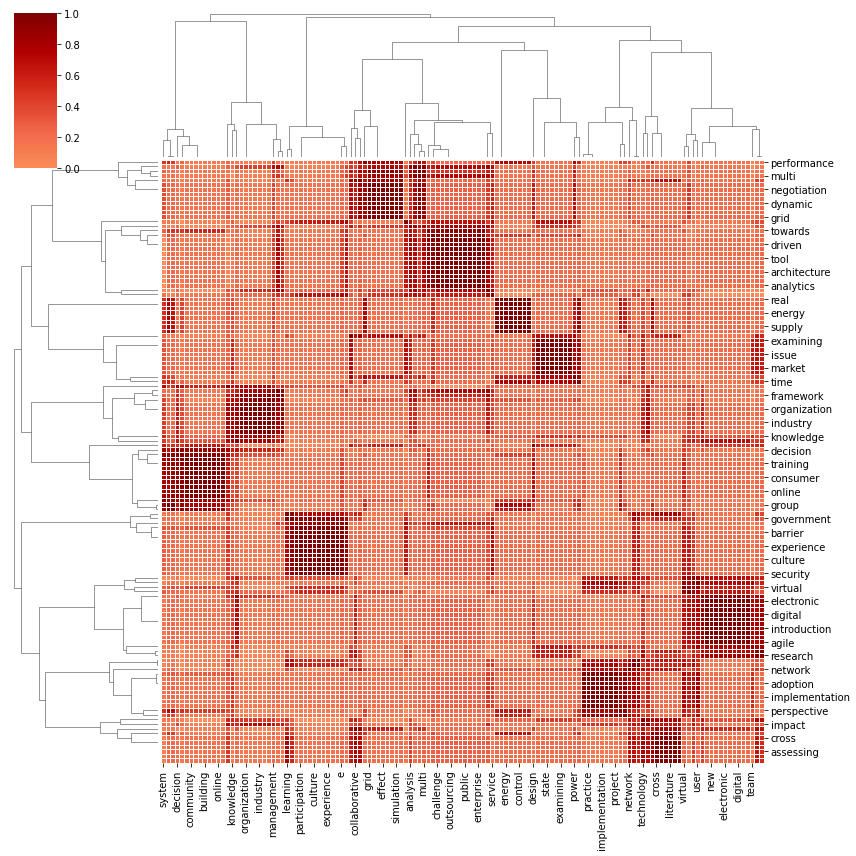

In [22]:
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="OrRd", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [23]:
pyLDAvis.enable_notebook()
panel = gensim_models.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
6      32.420952   8.115230       1        1  20.562189
0       0.648955  71.707100       2        1  18.332481
7      71.019684   9.971006       3        1  13.520509
1       3.785981  33.185135       4        1  13.191069
2     -42.666500  -9.222070       5        1   7.141890
8      -3.621689 -43.526516       6        1   7.028208
4      -3.632402  -4.171708       7        1   5.059589
5     -36.584400  35.804413       8        1   5.055575
3      44.391380  50.615383       9        1   5.054470
9      40.235809 -31.591665      10        1   5.054021, topic_info=             Term        Freq       Total Category  logprob  loglift
81         social   37.000000   37.000000  Default  30.0000  30.0000
65         system  127.000000  127.000000  Default  29.0000  29.0000
41     management   55.000000   55.000000  Default  28.0000  28.0000
996     minitrack   21.000000   21.000000  Default  27.0000  27.0000
995  introduction   22.000000   22.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
898      adoption    2.182442   19.861496  Topic10  -5.2060   0.7766
195          case    2.339943   44.244223  Topic10  -5.1363   0.0454
47    application    2.124834   30.695279  Topic10  -5.2328   0.3146
20        network    2.178497   53.640239  Topic10  -5.2078  -0.2187
460       project    2.005031   24.612906  Topic10  -5.2908   0.4774

[746 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
426       1  0.180393         '
426       2  0.045098         '
426       3  0.090196         '
426       4  0.405884         '
426       5  0.045098         '
...     ...       ...       ...
403       2  0.262728  workflow
403       6  0.262728  workflow
403      10  0.525457  workflow
1674      4  1.173066   writing
1488      3  0.985439      year

[1323 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 8, 2, 3, 9, 5, 6, 4, 10])

The above plot is a 2D mapped visualization of the distances between each of the generated topics through LDA. Hovering the mouse above a particular circle (which represents a topic) allows us to see important terms and words that make up that topic.

NOTE: Relevance is denoted by λ, the weight assigned to the probability of a term in a topic relative to its lift. When λ = 1, the terms are ranked by their probabilities within the topic (the ‘regular’ method) while when λ = 0, the terms are ranked only by their lift. Lift is the ratio of a term’s probability within a topic to its margin probability across the corpus.

Next we will take a look at some of the paper titles with maximum correspondence to the top topic words.

In [24]:
titles = plot_df['col'].values

count_vectorizer = CountVectorizer()
counts = count_vectorizer.fit_transform(titles)
tfidf_vectorizer = TfidfTransformer().fit(counts)
tfidf_abstracts = tfidf_vectorizer.transform(counts)

In [25]:
lda_model = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf_abstracts)
lda_W = lda_model.transform(tfidf_abstracts)
lda_H = lda_model.components_

In [26]:
def display_topics(H, W, feature_names, title_list, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("TOPIC %d:" % (topic_idx))
        print("Top Words: ",", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        print()
        print("Paper Titles:")
        for doc_index in top_doc_indices:
            print(title_list[doc_index])
        print()
        print('*' * 100)
            
no_top_words = 15
no_top_documents = 4     
title_list = df['title'].tolist()
tf_feature_names = count_vectorizer.get_feature_names()
display_topics(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)

TOPIC 0:
Top Words:  unit, graph, scheme, nonlinear, operating, blackout, fast, constrained, output, side, reward, reserve, air, multimedia, multiprocessor

Paper Titles:
Broadcast automata: a parallel scalable architecture for prototypal embedded processors for space applications
Epidemic analysis and visualization based on Digital Earth spatio-temporal framework
Modal Energy Trending for Ringdown Analysis in Power Systems Using Synchrophasors
Optical interconnects for multiprocessor architectures using wavelength-division multiplexing

****************************************************************************************************
TOPIC 1:
Top Words:  cloud, power, co, contribution, grid, computing, delivery, net, transmission, storage, system, wind, electric, resistance, generation

Paper Titles:
The Impact of Variable Market Price on Optimal Control of Wind-Hydro Storage System in Kenya
Nodal-price dependent, dual-mode transmission line protection strategy
Pedagogical Architect

## Analyzing the abstracts of the papers

In [27]:
# stop_words.update(['based', 'using', 'A', 'The'])
latex_regex = r"(\$+)(?:(?!\1)[\s\S])*\1"

## Cleaning the text of the abstract to remove or ignore unimportant symbols and characters
plot_df['tokenized_col'] = df.apply(lambda row: (re.sub("[^A-Za-z0-9' ]+", ' ', row['abstract'])),axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: (re.sub(latex_regex, "", row['tokenized_col'])),axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: row['tokenized_col'].lower(), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: (word_tokenize(row['tokenized_col'])), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([w for w in row['tokenized_col'] if w not in stop_words]), axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([lmtzr.lemmatize(w) for w in row['tokenized_col']]), axis=1)
plot_df['col'] = plot_df.apply(lambda row: ' '.join(row['tokenized_col']), axis=1)

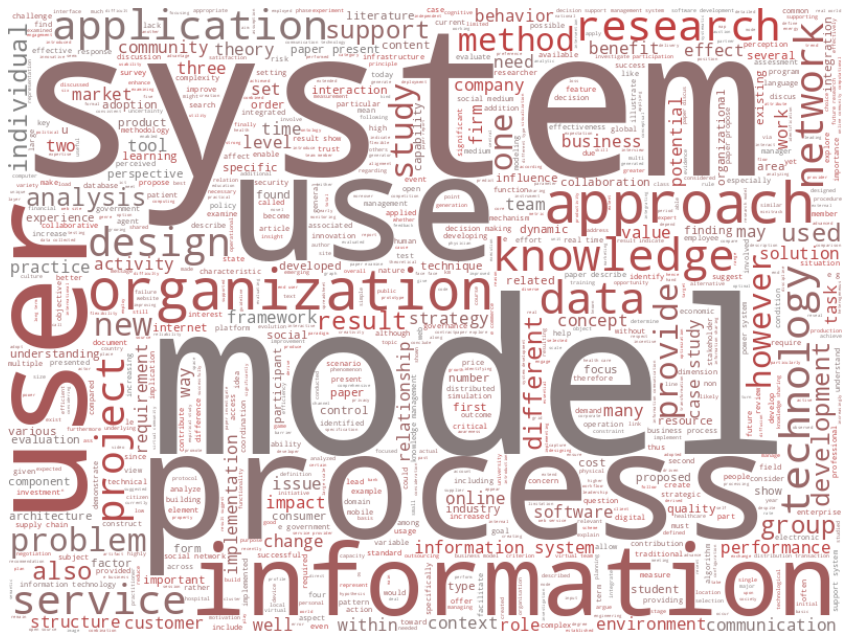

In [28]:
all_abstracts = ' '.join(plot_df['col'].str.lower())

wordcloud = WordCloud(stopwords=stop_words, background_color="white", 
                      max_words=1000, width=800, height=600).generate(all_abstracts)
default_colors = wordcloud.to_array() #convert to array for recoloring

rcParams['figure.figsize'] = 15, 25
plt.imshow(wordcloud.recolor(color_func=color_func), #apply recoloring using color function
           interpolation="bilinear")
plt.axis("off")
plt.show()

As expected, the word cloud from abstracts of the papers are pretty similar to that of the titles with pretty much the same words having higher frequencies of occurences in the abstracts.

### Ngram Analysis of Abstracts

In [29]:
def count_ngrams(dataframe,column,begin_ngram,end_ngram): 
    word_vectorizer = CountVectorizer(ngram_range=(begin_ngram,end_ngram), analyzer='word')
    sparse_matrix = word_vectorizer.fit_transform(dataframe[column].dropna())
    frequencies = sum(sparse_matrix).toarray()[0]
    most_common = pd.DataFrame(frequencies, 
                               index=word_vectorizer.get_feature_names(), 
                               columns=['frequency']).sort_values('frequency',ascending=False)
    most_common['ngram'] = most_common.index
    most_common.reset_index()
    return most_common

def word_cloud_function(df,column,number_of_words):
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    word_string=str(popular_words_nonstop)
    wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          max_words=number_of_words,
                          width=1000,height=1000,
                         ).generate(word_string)
    plt.clf()
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

def word_bar_graph_function(df,column,title):
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    plt.barh(range(50), [word_count_dict[w] for w in reversed(popular_words_nonstop[0:50])])
    plt.yticks([x + 0.5 for x in range(50)], reversed(popular_words_nonstop[0:50]))
    plt.title(title)
    plt.show()

In [30]:
two_grams = count_ngrams(plot_df,'col',2, 2)

fig = px.bar(two_grams.sort_values('frequency',ascending=False)[0:10].iloc[::-1], 
             x="frequency", 
             y="ngram",
             title='Most Common 2-Words in Abstracts of Papers',
             orientation='h')
fig.show()

In [31]:
three_grams = count_ngrams(plot_df,'col',3, 3)

fig = px.bar(three_grams.sort_values('frequency',ascending=False)[0:10].iloc[::-1], 
             x="frequency", 
             y="ngram",
             title='Most Common 3-Words in Abstracts of Papers',
             orientation='h')
fig.show()

For abstract, instead of using single words for topic modelling, we will be using ngrams in the range of [1,3]. Through this way, we should be able to capture more context from the abstract texts of the papers.

In [32]:
ngrams = Phrases(plot_df['tokenized_col'].values, min_count=1, threshold=3, delimiter=' ')

ngrams_phraser = Phraser(ngrams)

ngram_token = []
for sent in plot_df['tokenized_col'].values:
    ngram_token.append(ngrams_phraser[sent])

In [33]:
dictionary = corpora.Dictionary(ngram_token)
corpus = [dictionary.doc2bow(text) for text in ngram_token]

tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [34]:
total_topics = 10

lda = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tf

In [35]:
lda.show_topics(total_topics, 7)

[(0,
  '0.006*"process" + 0.004*"model" + 0.004*"mobile" + 0.003*"study" + 0.003*"virtual team" + 0.003*"paper" + 0.003*"environment"'),
 (1,
  '0.006*"system" + 0.006*"model" + 0.004*"process" + 0.004*"data" + 0.004*"analysis" + 0.003*"use" + 0.003*"group"'),
 (2,
  '0.006*"network" + 0.005*"information" + 0.005*"use" + 0.005*"model" + 0.005*"system" + 0.005*"data" + 0.004*"study"'),
 (3,
  '0.007*"system" + 0.007*"knowledge" + 0.006*"project" + 0.005*"process" + 0.005*"study" + 0.004*"research" + 0.003*"model"'),
 (4,
  '0.009*"process" + 0.007*"research" + 0.006*"study" + 0.006*"model" + 0.006*"knowledge" + 0.005*"theory" + 0.005*"organization"'),
 (5,
  '0.011*"research" + 0.006*"service" + 0.006*"model" + 0.005*"system" + 0.005*"study" + 0.004*"design" + 0.004*"technology"'),
 (6,
  '0.018*"system" + 0.007*"user" + 0.005*"technology" + 0.005*"model" + 0.005*"service" + 0.005*"research" + 0.005*"process"'),
 (7,
  '0.009*"information" + 0.007*"data" + 0.005*"model" + 0.004*"system"

In [36]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
df_lda

process     model    mobile     study  virtual team     paper  \
0  0.005549  0.003827  0.003534  0.003098      0.003009  0.002990   
1  0.004258  0.005810  0.000000  0.002555      0.000000  0.002438   
2  0.002033  0.005025  0.000000  0.003513      0.000000  0.000000   
3  0.005301  0.003176  0.000000  0.005136      0.000000  0.002510   
4  0.009142  0.006340  0.000000  0.006412      0.000000  0.003386   
5  0.002625  0.005540  0.000000  0.004557      0.000000  0.002429   
6  0.004567  0.005014  0.000000  0.004167      0.000000  0.000000   
7  0.002212  0.004748  0.000000  0.000000      0.000000  0.000000   
8  0.000000  0.007780  0.000000  0.004009      0.000000  0.002256   
9  0.008646  0.008128  0.000000  0.000000      0.000000  0.004447   

   environment  information    device      task  ...  business model  \
0     0.002785     0.002631  0.002323  0.002234  ...        0.000000   
1     0.000000     0.000000  0.000000  0.000000  ...        0.000000   
2     0.000000     0.005204  0.000000  0.000000  ...        0.000000   
3     0.000000     0.000000  0.000000  0.000000  ...        0.000000   
4     0.000000     0.003903  0.000000  0.000000  ...        0.000000   
5     0.000000     0.002141  0.000000  0.000000  ...        0.000000   
6     0.000000     0.004156  0.000000  0.000000  ...        0.000000   
7     0.000000     0.009382  0.000000  0.000000  ...        0.000000   
8     0.000000     0.000000  0.000000  0.000000  ...        0.002238   
9     0.000000     0.003424  0.000000  0.000000  ...        0.000000   

   open data  pricing      show      cost  framework  business process  \
0   0.000000    0.000  0.000000  0.000000   0.000000          0.000000   
1   0.000000    0.000  0.000000  0.000000   0.000000          0.000000   
2   0.000000    0.000  0.000000  0.000000   0.000000          0.000000   
3   0.000000    0.000  0.000000  0.000000   0.000000          0.000000   
4   0.000000    0.000  0.000000  0.000000   0.000000          0.000000   
5   0.000000    0.000  0.000000  0.000000   0.000000          0.000000   
6   0.000000    0.000  0.000000  0.000000   0.000000          0.000000   
7   0.000000    0.000  0.000000  0.000000   0.000000          0.000000   
8   0.002126    0.002  0.001971  0.001907   0.000000          0.000000   
9   0.000000    0.000  0.000000  0.000000   0.003375          0.003055   

       need  requirement    area  
0  0.000000     0.000000  0.0000  
1  0.000000     0.000000  0.0000  
2  0.000000     0.000000  0.0000  
3  0.000000     0.000000  0.0000  
4  0.000000     0.000000  0.0000  
5  0.000000     0.000000  0.0000  
6  0.000000     0.000000  0.0000  
7  0.000000     0.000000  0.0000  
8  0.000000     0.000000  0.0000  
9  0.002621     0.002538  0.0025  

[10 rows x 99 columns]

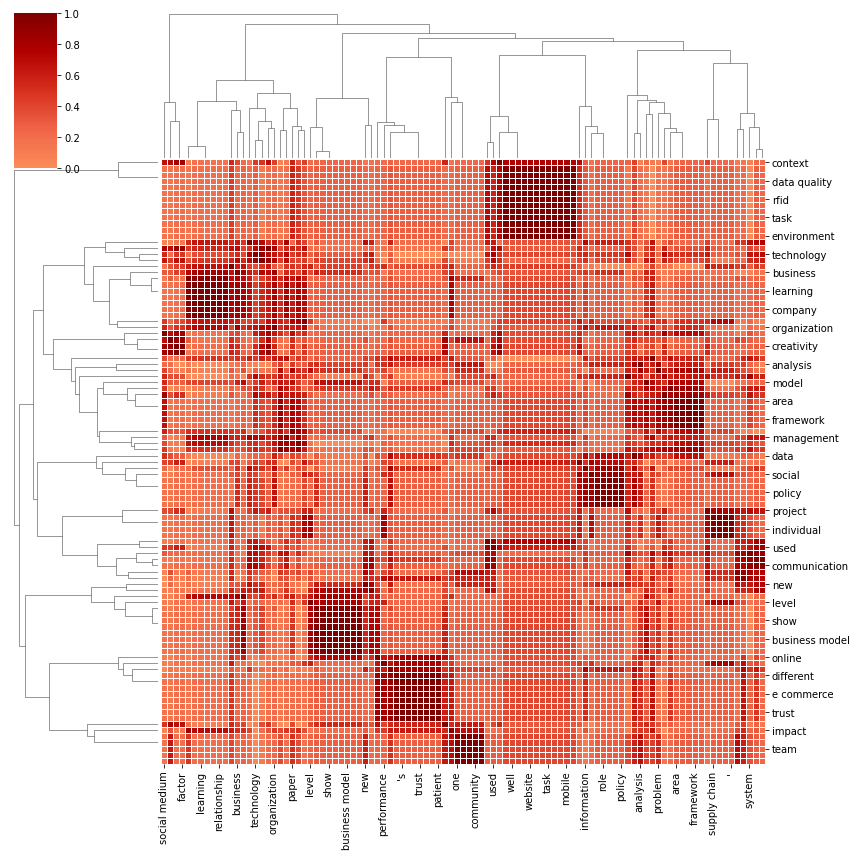

In [37]:
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="OrRd", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [38]:
pyLDAvis.enable_notebook()
panel = gensim_models.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning:

'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.



PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
2      32.420952   8.115230       1        1  24.484920
6       0.648955  71.707100       2        1  20.512678
9      71.019684   9.971006       3        1  12.957467
8       3.785981  33.185135       4        1   8.178638
5     -42.666500  -9.222070       5        1   6.888145
1      -3.621689 -43.526516       6        1   5.675225
7      -3.632402  -4.171708       7        1   5.435504
3     -36.584400  35.804413       8        1   5.308288
4      44.391380  50.615383       9        1   5.304752
0      40.235809 -31.591665      10        1   5.254383, topic_info=              Term       Freq      Total Category  logprob  loglift
389        process  33.000000  33.000000  Default  30.0000  30.0000
680       research  31.000000  31.000000  Default  29.0000  29.0000
670      knowledge  18.000000  18.000000  Default  28.0000  28.0000
77          system  59.000000  59.000000  Default  27.0000  27.0000
210    information  30.000000  30.000000  Default  26.0000  26.0000
...            ...        ...        ...      ...      ...      ...
42            data   0.659339  27.395731  Topic10  -6.4418  -0.7808
2152  organization   0.639667  17.920236  Topic10  -6.4721  -0.3866
35     application   0.622947  20.082043  Topic10  -6.4985  -0.5270
255            use   0.626983  32.583044  Topic10  -6.4921  -1.0045
77          system   0.616719  59.747928  Topic10  -6.5086  -1.6274

[843 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
399       1  0.121762         '
399       2  0.243525         '
399       3  0.121762         '
399       4  0.121762         '
399       6  0.121762         '
...     ...       ...       ...
238       8  0.074844      work
238       9  0.074844      work
238      10  0.074844      work
1619      3  0.433399  workflow
1619     10  0.433399  workflow

[893 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 10, 9, 6, 2, 8, 4, 5, 1])

In [39]:
abstracts = plot_df['col'].values

count_vectorizer = CountVectorizer(ngram_range=(1,3))
counts = count_vectorizer.fit_transform(abstracts)
tfidf_vectorizer = TfidfTransformer().fit(counts)
tfidf_abstracts = tfidf_vectorizer.transform(counts)

In [40]:
lda_model = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf_abstracts)
lda_W = lda_model.transform(tfidf_abstracts)
lda_H = lda_model.components_

In [41]:
def display_topics(H, W, feature_names, title_list, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("TOPIC %d:" % (topic_idx))
        print("Top Words: ",", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        print()
        print("Paper Titles:")
        for doc_index in top_doc_indices:
            print(title_list[doc_index])
        print()
        print('*' * 100)
            
no_top_words = 15
no_top_documents = 4     
title_list = df['title'].tolist()
tf_feature_names = count_vectorizer.get_feature_names()
display_topics(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)

TOPIC 0:
Top Words:  addiction mobile phone, addiction mobile, buzz, mobbing, ef, burnout, whisper, cc hospital, segue, anonymous social, anonymous social medium, rejection region, agile research, open online learning, phone addiction

Paper Titles:
Robust Network Routing under Cascading Failures
Accelerating instant question search with database techniques
Knowledge sharing and yahoo answers: everyone knows something
One meter to find them all: water network leak localization using a single flow meter

****************************************************************************************************
TOPIC 1:
Top Words:  system, information, model, knowledge, research, process, paper, service, study, technology, data, user, business, social, network

Paper Titles:
Introduction to Gamification: Motivations, Effects and Analytics Minitrack
Introduction to the asynchronous learning networks mini-track
Automated Anomaly Detection in Distribution Grids Using uPMU Measurements
Introduction

In [43]:
def get_representative_papers(H, W, feature_names, title_list, no_top_words, no_top_documents):
    representative_df = pd.DataFrame()
    for topic_idx, topic in enumerate(H):
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            representative_df = representative_df.append(df.iloc[doc_index])
    return representative_df
            
no_top_words = 30
no_top_documents = 350     
tf_feature_names = count_vectorizer.get_feature_names()
representative_df = get_representative_papers(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)
representative_df.drop_duplicates(inplace=True)
for col in ['ID_Article', 'communityId', 'ID_RelatedVenue', 'year']:
    representative_df[col] = representative_df[col].astype('int')

In [45]:
representative_df.to_csv("repr_22457.csv", index=False)
representative_df

ID_Article  communityId  ID_RelatedVenue  \
59500     1817755        22457             9475   
95498     1928909        22457            20358   
95493     2075109        22457            20358   
95443     2519509        22457            20348   
77171      955488        22457             9896   
...           ...          ...              ...   
53223      348759        22457             9438   
9980      2011131        22457              422   
77149     1498629        22457             9896   
77151     1330273        22457             9896   
95175     2579015        22457            20332   

                                                   title  year  \
59500    Robust Network Routing under Cascading Failures  2014   
95498  Accelerating instant question search with data...  2011   
95493  Knowledge sharing and yahoo answers: everyone ...  2008   
95443  One meter to find them all: water network leak...  2014   
77171  (How) will the revolution be retweeted?: infor...  2012   
...                                                  ...   ...   
53223  Augmenting CASE Tools with Hypertext: Desired ...  1997   
9980   Toward a multi-strategy and cooperative discov...  1995   
77149  Microblogging after a major disaster in China:...  2011   
77151             Ad-itudes: twitter users & advertising  2012   
95175  Scalable complex contract negotiation with str...  2014   

                                                abstract  
59500  We propose a dynamical model for cascading fai...  
95498  Distributed question answering services, like ...  
95493  Yahoo Answers (YA) is a large and diverse ques...  
95443  Leak localization is a major issue faced by wa...  
77171  This paper examines microblogging information ...  
...                                                  ...  
53223  Information systems have become bigger and mor...  
9980   We have been developing a methodology/system c...  
77149  In this work, we conducted a case study of a p...  
77151  Advertising offline and online is pervasive. T...  
95175  A large number of interdependent issues in com...  

[959 rows x 6 columns]